<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Dynamic Hedge Ratio Using the Kalman Filter



# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import pandas as pd
import statsmodels.tsa.stattools as ts
import pandas_datareader as pdr
import datetime as dt
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from matplotlib import rcParams

rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

# Cointegration
<hr style = "border:2px solid black" ></hr>

 
- It is difficult to find mean-reverting asset as equities broadly behave like GBMs and hence render the mean-reverting trade strategies relatively useless. 
- However, we can still create a portfolio of price series that is stationary so we can apply a mean-reverting trading strategies.
- The **pairs trade** does exactly this. Two companies in the same sector are likely to be exposed to similar market factors, which affect their businesses. Occasionally their relative stock prices will diverge due to certain events, but will revert to the long-running mean.



# Dynamic Hedge Ratio 
<hr style = "border:2px solid black" ></hr>

 
- A common quant trading technique involves taking two assets that form a cointegrating relationship and utilising a mean-reverting approach to construct a trading strategy. This can be carried out by performing a linear regression between the two assets.

- Any parameters introduced via this structural relationship such as the hedging ratio between the two assets are likely to be time-varying, thus we need to find a way for adjusting the hedging ratio over time.

- One approach to this problem is to utilise a rolling linear regression with a lookback window for which the lookback window length must be found often via cross-validation.

- A more sophisticated approach is to utilise a state space model that treats the "true" hedge ratio as an unobserved hidden variable and attempts to estimate it with "noisy" observations. In our case this means the pricing data of each asset. The **Kalman filter** performs exactly this task. 



# Imports
<hr style = "border:2px solid black" ></hr>

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pandas_datareader as pdr 
from pykalman import KalmanFilter

# Get the data
<hr style = "border:2px solid black" ></hr>

 
- We are going to consider two fixed income ETFs, namely the iShares 20+ Year Treasury Bond ETF (TLT) and the iShares 3-7 Year Treasury Bond ETF (IEI). 
- Both ETFs track the performance of varying duration US Treasury bonds and as such are both exposed to similar market factors.



In [3]:
# Choose the ETF symbols to work with along with 
# start and end dates for the price histories 
etfs = ["TLT", "IEI"]
start_date = "2010-8-01"
end_date = "2016-08-01"

In [4]:
# Obtain the adjusted closing prices from Yahoo finance
etf_df1 = pdr.get_data_yahoo(etfs[0], start_date, end_date) 
etf_df2 = pdr.get_data_yahoo(etfs[1], start_date, end_date)

In [5]:
prices = pd.DataFrame(index=etf_df1.index)
prices[etfs[0]] = etf_df1["Adj Close"]
prices[etfs[1]] = etf_df2["Adj Close"]

In [9]:
prices

,TLT,IEI
Date,,
2010-08-02,72.597519,98.718422
2010-08-03,73.016525,99.144135
2010-08-04,72.457840,98.820641
2010-08-05,72.795990,99.084572
2010-08-06,73.589989,99.391045
...,...,...
2016-07-26,121.896927,116.036224
2016-07-27,123.414886,116.320435
2016-07-28,123.186821,116.393776


# EDA
<hr style = "border:2px solid black" ></hr>

/var/folders/5x/lyqr8wv507n43bnwpsz4dq_c0000gn/T/ipykernel_45171/3649621298.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.ax.set_yticklabels(


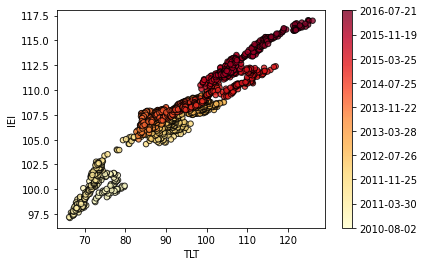

In [6]:
"""
Create a scatterplot of the two ETF prices, which is
coloured by the date of the price to indicate the
changing relationship between the sets of prices
"""

# Create a yellow-to-red colourmap where yellow indicates
# early dates and red indicates later dates
plen = len(prices)
colour_map = plt.cm.get_cmap("YlOrRd")
colours = np.linspace(0.1, 1, plen)
# Create the scatterplot object
scatterplot = plt.scatter(
    prices[etfs[0]], prices[etfs[1]],
    s=30, c=colours, cmap=colour_map,
    edgecolor="k", alpha=0.8
)
# Add a colour bar for the date colouring and set the
# corresponding axis tick labels to equal string-formatted dates
colourbar = plt.colorbar(scatterplot)
colourbar.ax.set_yticklabels(
    [str(p.date()) for p in prices[::plen//9].index])
plt.xlabel(prices.columns[0])
plt.ylabel(prices.columns[1])
plt.show()

# Kalman filter
<hr style = "border:2px solid black" ></hr>

In [7]:
"""
Utilise the Kalman Filter from the PyKalman package
to calculate the slope and intercept of the regressed
ETF prices.
"""

delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = np.vstack(
    [prices[etfs[0]], np.ones(prices[etfs[0]].shape)]).T[:, np.newaxis]
kf = KalmanFilter(
    n_dim_obs=1,
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)
state_means, state_covs = kf.filter(prices[etfs[1]].values)

# Post-processing
<hr style = "border:2px solid black" ></hr>

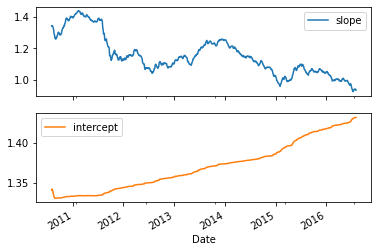

In [8]:
# Plot the slope and intercept changes from the Kalman Filter calculated values.

pd.DataFrame(
    dict(
        slope=state_means[:, 0], intercept=state_means[:, 1]
    ), index=prices.index
).plot(subplots=True)
plt.show()


# Conclusions
<hr style = "border:2px solid black" ></hr>


- We have mentioned how using a rolling mean would have required to perform a cross-validated procedure to find the window.
- **Be aware that**, if this was to be put into production as a live trading strategy it would be necessary to
optimise the delta parameter across baskets of pairs of ETFs utilising cross-validation.



# References
<hr style = "border:2px solid black" ></hr>


- https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing/
- https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing-Part-II/
- https://www.quantstart.com/advanced-algorithmic-trading-ebook/ 

